<a href="https://colab.research.google.com/github/Evan-eng/anthropic_superposition_experiment_recreation/blob/main/demonstrating_superposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import torch
import random
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, replace
from tqdm.notebook import trange

In [157]:
@dataclass
class Config:
  features: int
  hidden: int
  instances: int
  importance: float
  sparsity: float

# Define linear model where
# layer 1: h = Wx
# layer 2: x' = W^T h + b
class linear_model(nn.Module):
  def __init__(self, config, feature_probabilities, importance):
    super().__init__()

    self.config = config
    self.feature_probabilities = feature_probabilities
    self.importance = importance

    self.layer1 = nn.Linear(config.features, config.hidden, bias=False)
    self.layer2 = nn.Linear(config.hidden, config.features)
    self.layer2.weight = nn.Parameter(self.layer1.weight.T.float())

  def forward(self, x):
    h = self.layer1(x)
    return self.layer2(h)


# Define ReLU model where
# layer 1: h = Wx
# layer 2: x' = relu(W^T h + b)
class relu_model(nn.Module):
  def __init__(self, config, feature_probabilities, importance):
    super().__init__()

    self.config = config
    self.feature_probabilities = feature_probabilities
    self.importance = importance

    self.layer1 = nn.Linear(config.features, config.hidden, bias=False)
    self.layer2 = nn.Linear(config.hidden, config.features)
    self.relu = nn.ReLU()
    self.layer2.weight = nn.Parameter(self.layer1.weight.T.float())

  def forward(self, x):
    h = self.layer1(x)
    return self.relu(self.layer2(h))

def custom_loss(x, x_prime, importance):
    return (imp[None, :] * (x_instances - x_prime)**2).sum()



def optimize(model, steps=15000, lr=1e-3):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr)
    x_instances = model.feature_probabilities

    for i in range(steps):
        optimizer.zero_grad()
        output = model(x_instances)
        loss = custom_loss(x_instances, output, model.importance)
        loss = loss.sum()
        loss.backward()
        optimizer.step()


# Generate a feature vector x where x_i = 0 with p(s) and is otherwise uniformly
# distributed between [0, 1]
def x_input(n_instances, n_features, sparsity):
    x_instances = torch.rand(n_instances, n_features)
    to_drop = torch.rand_like(x_instances) > sparsity
    x_instances *= to_drop.float()
    return x_instances


# Generate importance tensor where I_i = 0.9 ^ i
def importance(n, I):
  return torch.pow(torch.tensor(I), torch.arange(n))

config = Config(features=20, hidden=5, importance=0.7, sparsity = 0, instances = 100)

In [158]:
x_instances = x_input(config.instances, config.features, config.sparsity)
imp = importance(config.features, config.importance)

print(imp)
print(x_instances)

tensor([1.0000, 0.7000, 0.4900, 0.3430, 0.2401, 0.1681, 0.1176, 0.0824, 0.0576,
        0.0404, 0.0282, 0.0198, 0.0138, 0.0097, 0.0068, 0.0047, 0.0033, 0.0023,
        0.0016, 0.0011])
tensor([[0.5869, 0.3548, 0.3576,  ..., 0.7120, 0.5946, 0.1868],
        [0.6576, 0.0653, 0.0467,  ..., 0.7804, 0.3563, 0.5723],
        [0.6599, 0.1308, 0.4915,  ..., 0.9351, 0.1167, 0.9346],
        ...,
        [0.4535, 0.5569, 0.7997,  ..., 0.3293, 0.8419, 0.3769],
        [0.3865, 0.2457, 0.9957,  ..., 0.6947, 0.4872, 0.8579],
        [0.3735, 0.0883, 0.6220,  ..., 0.7999, 0.5121, 0.1651]])


In [159]:
linear_model = linear_model(config, x_instances, imp)
optimize(linear_model)

W1 = linear_model.layer2.weight.detach().numpy()
b1 = linear_model.layer2.bias.detach().numpy()
linear_result = np.dot(W1, W1.T)


relu_model = relu_model(config, x_instances, imp)
optimize(relu_model)

W2 = relu_model.layer2.weight.detach().numpy()
b2 = relu_model.layer2.bias.detach().numpy()
relu_result = np.dot(W2, W2.T)

[ 0.12863211 -0.05186929  0.13611147  0.13309684 -0.12767829  0.4931754
  0.5239233   0.31483936  0.7521904   0.34842476  0.27714545  0.54981154
  0.71307844  0.18603723  0.25937214  0.3750675   0.2894207   0.47908705
  0.5867259   0.09293026]


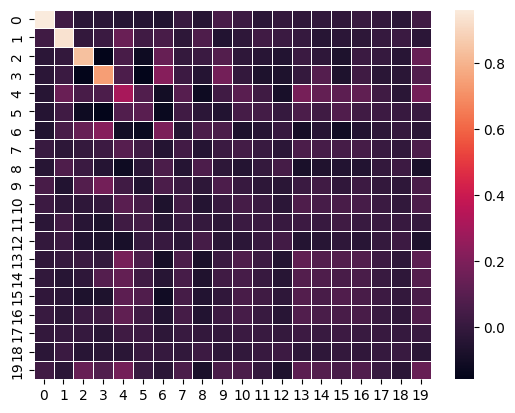

In [160]:
import seaborn as sns

print(b1)
ax = sns.heatmap(linear_result, linewidth=0.5)
plt.show()

[ 0.08112394  0.03043466  0.1058823   0.25851452 -0.0928008   0.52177125
  0.6364359  -0.27861145  0.5412722   0.49653786  0.34717208  0.57464665
  0.60050577  0.3820205   0.46048057 -0.22532062  0.46197695  0.50886977
  0.56370723  0.27958542]


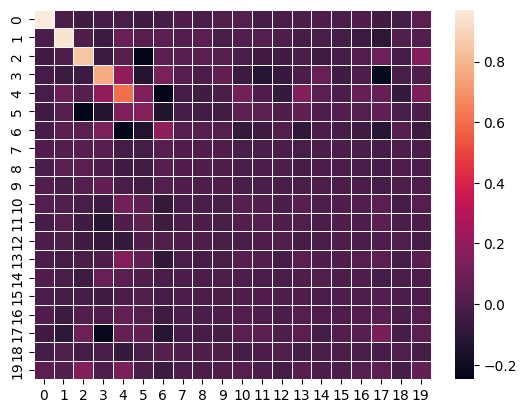

In [161]:
print(b2)
ax = sns.heatmap(relu_result, linewidth=0.5)
plt.show()